# Final project - E-Commerce: Product Range Analysis
The goal of this project is to study and analyze the product sales of a store, thus provide the business with information on the profitability and popularity of the products, and come up with conclusions and recommendations that will help in making dcisions regrading the product range.

**Task decomposition**
- General information on the data
- Data preparation - data types conversion, rename columns, add new column as neede, address missing values and duplicates, address negative values
- Exploratory data analysis - study distributions of core parameters, detect outliers and define limits, study relationships between variables, study the variable distributions over time.
- Product range analysis - building a product score, categorize the products by score groups, focus on the highest scores, look for paired products (common sequential orders), find leading products by core parameters, investigate seasonality.
- Conclusions and recommendations

**Project Presentation:** [link to cloud storage](<https://drive.google.com/drive/folders/1VzvsiZytNmf4_bMNHPlfBi3AcRPnff7e?usp=sharing>)

## Data Overview and Preprocessing

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from itertools import combinations
from collections import Counter
from scipy import stats as st
import math

**General information**

In [107]:
data = pd.read_csv('/Data Analysis/final project/ecommerce_dataset_us.csv', sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 28.9+ MB


In [108]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,11/29/2018 08:26,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,11/29/2018 08:26,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,11/29/2018 08:26,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,11/29/2018 08:26,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,11/29/2018 08:26,3.39,17850.0


**Missing values and duplicates:** 

Missing values share (%) in each column:

In [109]:
data.isna().sum() / len(data) * 100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
dtype: float64

There are missing values in 'Description' (2.7%) and 'CustomerID' (25%).<br> 
Study the observations where the 'description' is missing:

In [110]:
data[data['Description'].isna()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
622,536414,22139,NaN,56,11/29/2018 11:52,0.0,NaN
1970,536545,21134,NaN,1,11/29/2018 14:32,0.0,NaN
1971,536546,22145,NaN,1,11/29/2018 14:33,0.0,NaN
1972,536547,37509,NaN,1,11/29/2018 14:33,0.0,NaN
1987,536549,85226A,NaN,1,11/29/2018 14:34,0.0,NaN


We notice of a probable pattern for the description missing values, as these observations have 0 value in unit price. <br>
Checking for values frequency in 'description' column:

In [111]:
data[data['Description'].isna()]['UnitPrice'].value_counts()

0.0    1454
Name: UnitPrice, dtype: int64

Indeed, all the observations where description is missing have a zero unit price, hence this data will probably not be of use in our analysis. We'll drop tese rows:

In [112]:
data = data.dropna(subset=['Description'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 540455 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    540455 non-null  object 
 1   StockCode    540455 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     540455 non-null  int64  
 4   InvoiceDate  540455 non-null  object 
 5   UnitPrice    540455 non-null  float64
 6   CustomerID   406829 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 33.0+ MB


As for the missing values of the 'CustomerID' column, the best option is to leave it as it is. Their share of all customers is not negligible, there's no plausible solution for filling them, and they are not of crucial importance for further analysis anyway.

Looking for duplicates, dropping if there are any:

In [113]:
data.duplicated().sum()

5268

In [114]:
data = data.drop_duplicates()
data.duplicated().sum()

0

**Data types, columns names:**<br>
We'll convert the 'InvoiceDate' column from object to datetime type:

In [115]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%m/%d/%Y %H:%M')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535187 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    535187 non-null  object        
 1   StockCode    535187 non-null  object        
 2   Description  535187 non-null  object        
 3   Quantity     535187 non-null  int64         
 4   InvoiceDate  535187 non-null  datetime64[ns]
 5   UnitPrice    535187 non-null  float64       
 6   CustomerID   401604 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 32.7+ MB


For the sake of convenience, renaming the columns names to lowercase with underscores: 

In [116]:
data = data.rename(columns={
    'InvoiceNo' : 'invoice',
    'StockCode' : 'stock_code',
    'Description' : 'description',
    'Quantity' : 'quantity',
    'InvoiceDate' : 'invoice_date',
    'UnitPrice' : 'unit_price',
    'CustomerID' : 'customer_id'
})

In [117]:
data.columns

Index(['invoice', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id'],
      dtype='object')

Checking for date range:

In [118]:
data['invoice_date'].min(), data['invoice_date'].max()

(Timestamp('2018-11-29 08:26:00'), Timestamp('2019-12-07 12:50:00'))

The data time range is about a year.

Study unit price column and check for anomalies:

In [119]:
data['unit_price'].describe()

count    535187.000000
mean          4.645242
std          97.364810
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: unit_price, dtype: float64

The unit price data contain negative values and extremely high values, we'll investigate both:

In [120]:
data[data['unit_price'] < 0]

,invoice,stock_code,description,quantity,invoice_date,unit_price,customer_id
299983,A563186,B,Adjust bad debt,1,2019-08-10 14:51:00,-11062.06,NaN
299984,A563187,B,Adjust bad debt,1,2019-08-10 14:52:00,-11062.06,NaN


Only two observations has negative unit price, descripted as 'Adjust bad debt'. Presumably this description accounts for orders that will not be paid for some reason.

In [121]:
data[['description','quantity','unit_price']].sort_values(by='unit_price', ascending=False).head(10)

,description,quantity,unit_price
222681,Manual,-1,38970.00
524602,AMAZON FEE,-1,17836.46
43702,AMAZON FEE,-1,16888.02
43703,AMAZON FEE,-1,16453.71
16356,AMAZON FEE,-1,13541.33
15016,AMAZON FEE,-1,13541.33
15017,AMAZON FEE,1,13541.33
16232,AMAZON FEE,-1,13474.79
524601,AMAZON FEE,-1,11586.50
299982,Adjust bad debt,1,11062.06


The highest unit prices are of 'Manual' - currently a transaction of unknwon origin, and 'AMAZON FEE' - probably represents the costs of selling on Amazon.

Now we'll make this brief study for 'quantity' data:

In [122]:
data['quantity'].describe()

count    535187.000000
mean          9.671593
std         219.059056
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: quantity, dtype: float64

The quantity data contains negative values and extreme outliers. Most of the values seem to be in ligical range though, as much as we can conclude from the interquartile range as described above. <br>
Lets check the negative values:

In [123]:
data[data['quantity'] < 0]

,invoice,stock_code,description,quantity,invoice_date,unit_price,customer_id
141,C536379,D,Discount,-1,2018-11-29 09:41:00,27.50,14527.0
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2018-11-29 09:49:00,4.65,15311.0
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2018-11-29 10:24:00,1.65,17548.0
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548.0
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548.0
...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2019-12-07 09:57:00,0.83,14397.0
541541,C581499,M,Manual,-1,2019-12-07 10:28:00,224.69,15498.0
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2019-12-07 11:57:00,10.95,15311.0
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2019-12-07 11:58:00,1.25,17315.0


As shown in the above table, the items that account for negative quantity value are 'Discount', 'Manual' or a real product. We can assume that the negative quantity of product in that list means refund.

**Adding columns:**<br>
To ease the next stages of analysis, we'll add columns of useful information.<br>
Start with revenue column, which is calculated by multiply quantity by unit price and represent the revenue from each item in each invoice.

In [124]:
data['revenue'] = data['quantity'] * data['unit_price']
data.head()

,invoice,stock_code,description,quantity,invoice_date,unit_price,customer_id,revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850.0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850.0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850.0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850.0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850.0,20.34


Adding date column from the invoice_date timestamp, converting the new column to datetime type:

In [125]:
data['date'] = data['invoice_date'].dt.date
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

**Filtering the data for analysis:**<br>
Before we start the EDA part, we'll filter the dataset and extract the negative values data in price and quantity columns. We'll be using the extracted data later when focusing on refunded products. 

In [126]:
new_df = data[(data['quantity'] > 0) & (data['unit_price'] > 0)]
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 524878 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice       524878 non-null  object        
 1   stock_code    524878 non-null  object        
 2   description   524878 non-null  object        
 3   quantity      524878 non-null  int64         
 4   invoice_date  524878 non-null  datetime64[ns]
 5   unit_price    524878 non-null  float64       
 6   customer_id   392692 non-null  float64       
 7   revenue       524878 non-null  float64       
 8   date          524878 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1), object(3)
memory usage: 40.0+ MB


In [127]:
new_df['unit_price'].describe()

count    524878.000000
mean          3.922573
std          36.093028
min           0.001000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: unit_price, dtype: float64

In [128]:
new_df.sort_values(by='unit_price', ascending=False).head(15)

,invoice,stock_code,description,quantity,invoice_date,unit_price,customer_id,revenue,date
15017,537632,AMAZONFEE,AMAZON FEE,1,2018-12-05 15:08:00,13541.33,NaN,13541.33,2018-12-05
299982,A563185,B,Adjust bad debt,1,2019-08-10 14:50:00,11062.06,NaN,11062.06,2019-08-10
173382,551697,POST,POSTAGE,1,2019-05-01 13:46:00,8142.75,16029.0,8142.75,2019-05-01
297723,562955,DOT,DOTCOM POSTAGE,1,2019-08-09 10:14:00,4505.17,NaN,4505.17,2019-08-09
268028,560373,M,Manual,1,2019-07-16 12:30:00,4287.63,NaN,4287.63,2019-07-16
422351,573077,M,Manual,1,2019-10-25 14:13:00,4161.06,12536.0,4161.06,2019-10-25
422376,573080,M,Manual,1,2019-10-25 14:20:00,4161.06,12536.0,4161.06,2019-10-25
406406,571751,M,Manual,1,2019-10-17 11:18:00,3949.32,12744.0,3949.32,2019-10-17
374542,569382,M,Manual,1,2019-10-01 16:44:00,3155.95,15502.0,3155.95,2019-10-01
347948,567353,M,Manual,1,2019-09-17 16:14:00,2653.95,NaN,2653.95,2019-09-17


After extracting the negative values and outliers we can see that the unit price distribution mean and median are 3.9 and 2.1 respectively. The above table present the highest price items, and shows these unit price outliers are AMAZON FEE, Adjust bad debt, POSTAGE and DOTCOM POSTAGE. The latter is probably related to postage costs, and even without approving that assumption it is clear that these are not items sold, thus don't have influence on products sales and are not relevant for our analysis.<br>
We'll keep that in mind when applying further filtering to the data when performing the EDA part.

Now that we handled most of the issues of the data preparation, we'll proceed to Exploratory Data Analysis (EDA).

## Exploratory Data Analysis (EDA)

Before studying the numeric data, lets check the dates range of our filtered data:

In [129]:
new_df['date'].min(), new_df['date'].max()

(Timestamp('2018-11-29 00:00:00'), Timestamp('2019-12-07 00:00:00'))

**Core Parameters Distribution**<br>
We'll start with study of the quantitative variables - quantity, unit price and revenue, showing the distributions in histograms.<br>

In [130]:
new_df['quantity'].describe()

count    524878.000000
mean         10.616600
std         156.280031
min           1.000000
25%           1.000000
50%           4.000000
75%          11.000000
max       80995.000000
Name: quantity, dtype: float64

There's an extreme outlier of 80995 items in one order, lets take a look at this one and check the quantities that follow in a desceding order:

In [131]:
new_df.sort_values(by='quantity', ascending=False)

,invoice,stock_code,description,quantity,invoice_date,unit_price,customer_id,revenue,date
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2019-12-07 09:15:00,2.08,16446.0,168469.60,2019-12-07
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2019-01-16 10:01:00,1.04,12346.0,77183.60,2019-01-16
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2019-10-25 12:26:00,0.21,12901.0,1008.00,2019-10-25
206121,554868,22197,SMALL POPCORN HOLDER,4300,2019-05-25 10:52:00,0.72,13135.0,3096.00,2019-05-25
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2019-02-20 10:43:00,0.82,18087.0,3202.92,2019-02-20
...,...,...,...,...,...,...,...,...,...
98927,544687,21360,JOY LARGE WOOD LETTERS,1,2019-02-20 17:25:00,9.95,13184.0,9.95,2019-02-20
360429,568227,84519A,TOMATO CHARLIE+LOLA COASTER SET,1,2019-09-24 10:57:00,1.25,17841.0,1.25,2019-09-24
360430,568227,22196,SMALL HEART MEASURING SPOONS,1,2019-09-24 10:57:00,0.85,17841.0,0.85,2019-09-24
360433,568227,21934,SKULL SHOULDER BAG,1,2019-09-24 10:57:00,1.65,17841.0,1.65,2019-09-24


We can notice of two extremely high values at the top, which are not representative of the quantity data, and many orders of 1 piece at the bottom.<br>
Lets visualize the distribution with a histogram:

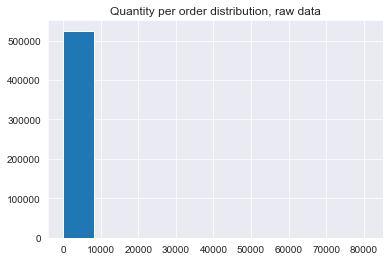

In [132]:
new_df['quantity'].hist()
plt.title('Quantity per order distribution, raw data')
plt.show()

At this point we can't learn anything from the quantity histogram because of the presence of extreme oultiers. <br>
We'll handle this issue right away after studying the other columns, and visualize the new distributions for the filtered data.

Now we'll check the distribution and statistics of the other two quantitative columns:

In [133]:
new_df['unit_price'].describe()

count    524878.000000
mean          3.922573
std          36.093028
min           0.001000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: unit_price, dtype: float64

The max value in relation to the mean and median indicate the presence of outliers.<br>

In [134]:
new_df.sort_values(by='unit_price', ascending=False).head()

,invoice,stock_code,description,quantity,invoice_date,unit_price,customer_id,revenue,date
15017,537632,AMAZONFEE,AMAZON FEE,1,2018-12-05 15:08:00,13541.33,NaN,13541.33,2018-12-05
299982,A563185,B,Adjust bad debt,1,2019-08-10 14:50:00,11062.06,NaN,11062.06,2019-08-10
173382,551697,POST,POSTAGE,1,2019-05-01 13:46:00,8142.75,16029.0,8142.75,2019-05-01
297723,562955,DOT,DOTCOM POSTAGE,1,2019-08-09 10:14:00,4505.17,NaN,4505.17,2019-08-09
268028,560373,M,Manual,1,2019-07-16 12:30:00,4287.63,NaN,4287.63,2019-07-16


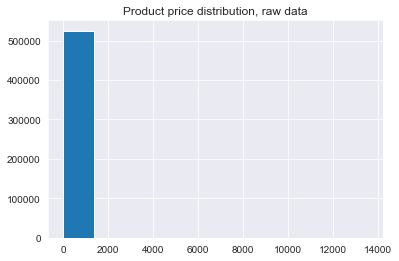

In [135]:
new_df['unit_price'].hist()
plt.title('Product price distribution, raw data')
plt.show()

As we already observed in the quantity histogram, the raw data contain extreme outliers and provide us with very limited knowledge.

**Defining upper limit for outliers:**<br>
In order to determine the upper limit, we'll calculate in two different ways and make a decision.<br>
The first is the Interquartile range:

In [136]:
quant_var = ['quantity','unit_price','revenue']
for i in quant_var:
    Q1 = np.percentile(new_df[i], 25)
    Q3 = np.percentile(new_df[i], 75)
    IQR = Q3-Q1
    print('Upper limit for outliers in', i, 'data:',  + 1.5*(IQR))

Upper limit for outliers in quantity data: 15.0
Upper limit for outliers in unit_price data: 4.32
Upper limit for outliers in revenue data: 20.700000000000003


The second is finding the 98th percentile:

In [137]:
for i in quant_var:
    print('The 98th percentile in', i, 'data:', np.percentile(new_df[i], 98))

The 98th percentile in quantity data: 72.0
The 98th percentile in unit_price data: 14.95
The 98th percentile in revenue data: 122.39999999999999


The two calculations suggest singnificantly different values. Since we want to prevent dropping products that might turn out to be profitable at later stages of the analysis, we'll use the wider range - the 98th percentile.

Filtering the data, taking out the oultiers - the values above the 98th percentile:

In [138]:
for column in quant_var:
    new_df = new_df[new_df[column] <= np.percentile(new_df[column], 98)]

In [139]:
print('Filtered data share of original data:', new_df.shape[0] / data.shape[0] *100)

Filtered data share of original data: 92.67190720252921


Creating a function to plot the histograms distribtion without outliers, and passing the quantitative columns to the function:

In [140]:
def column_hist(column):
    """
    This function takes a column as an argument and plot a histogram
    """
    plt.figure(figsize=(11,7))
    sns.histplot(data=new_df, x=column, bins=30)
    sns.set_style('darkgrid')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(column + ' distribution')
    plt.show()

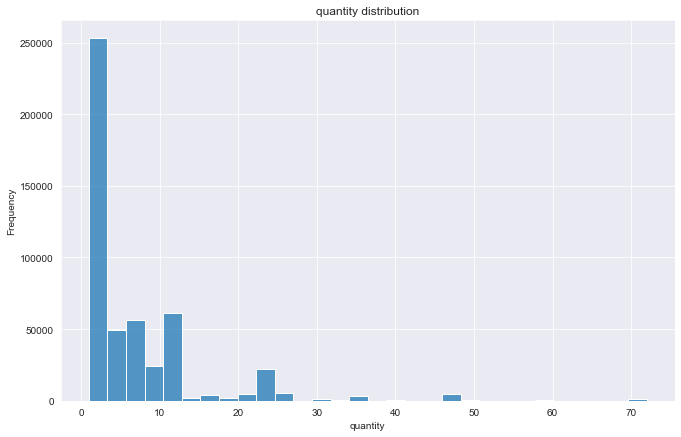

In [141]:
column_hist('quantity')

Most of the orders are of 1-2 pieces/items per orers, and the vast majority of values are concentrated up to 12 per order.

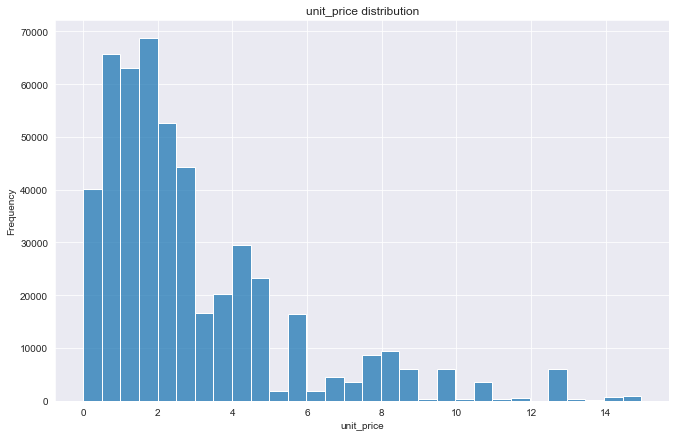

In [142]:
column_hist('unit_price')

The unit price right-skewed distribution shows that most of the products are priced 5 or less, with the highest frequency between 1-2.

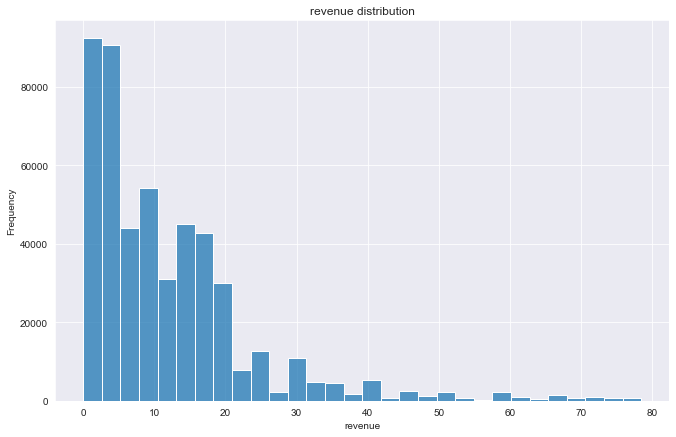

In [143]:
column_hist('revenue')

The revenue from orders, which is the product of qunatity and unit price of each order, shows a noticable amount of orders between 4-8, as most of the overall orders revenue is less than 20.

**Relationships between variables - corrlation matrix and correlation scatterplot**<br>
We'll group the data by products and check the relationships between the variables (quantitatvie) using a correlation matrix:

In [144]:
group_by_products = new_df.groupby('description')[['quantity','unit_price','revenue']].sum().reset_index()
group_by_products.head()

,description,quantity,unit_price,revenue
0,4 PURPLE FLOCK DINNER CANDLES,142,95.57,285.70
1,50'S CHRISTMAS GIFT BAG LARGE,1515,182.99,1927.63
2,DOLLY GIRL BEAKER,1051,259.73,1374.25
3,I LOVE LONDON MINI BACKPACK,248,390.00,1083.02
4,I LOVE LONDON MINI RUCKSACK,1,4.15,4.15


In [145]:
group_by_products[['quantity','unit_price','revenue']].corr()

,quantity,unit_price,revenue
quantity,1.000000,0.389813,0.718386
unit_price,0.389813,1.000000,0.871739
revenue,0.718386,0.871739,1.000000


The correlation matrix indicates a strong positive correlation for quantity-revenue (r=0.72) and unit price-revenue (r=0.87) pairs, while quantity-unit price vaiables are weakly correlated (r=0.39). <br>
Although looks pretty obvious, this finding means that the greater the quantity or the price of the product, the higher the revenue from this product.

<Figure size 792x504 with 0 Axes>

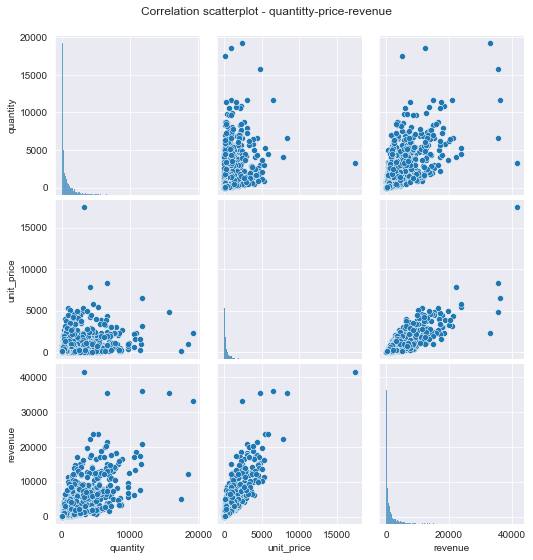

In [146]:
plt.figure(figsize=(11,7))
pp = sns.pairplot(group_by_products)
pp.fig.suptitle('Correlation scatterplot - quantitty-price-revenue', y=1.03)
plt.show()

In the pairs relationship plot we get a visualization of the variables correlations that were displayed in the correlation matrix. <br>
The quatity-revenue and unit price-revenue scatterplots indicates a strong positive correlation, While the quantity-unit price scatterplot present a weak correlation. <br>
We can also notice of a small amount of outliers out of the mass of values concentration. However, this time the plot is based on the grouped data by description, means that each observation in the scatterplots represents a total value of variable for a specific product. 

**Variables distribution over time**<br>
Another aspect that might contribute useful information to our analysis is the variables distribution over time.<br>
We'll group the filtered data by date, taking into account total quantity, total number of orders, and total revenues for each day. <br>
Then build a function to show the variables over time:  

In [147]:
sales_by_day = new_df.groupby(['date']).agg({'quantity':'sum', 'invoice':'nunique', 'revenue':'sum'})\
.reset_index()
sales_by_day['month'] = sales_by_day['date'].dt.to_period('M')
sales_by_day.head()

,date,quantity,invoice,revenue,month
0,2018-11-29,15933,112,33476.68,2018-11
1,2018-11-30,15812,129,27745.04,2018-11
2,2018-12-01,10175,61,24085.96,2018-12
3,2018-12-03,12640,84,24081.46,2018-12
4,2018-12-04,16744,99,37858.09,2018-12


In [148]:
sales_by_day['week'] = sales_by_day['date'] - pd.to_timedelta(
    sales_by_day['date'].dt.weekday, unit='D')
sales_by_week = sales_by_day.groupby(['week']).agg({
    'quantity':'sum', 'invoice':'sum', 'revenue':'sum'}).reset_index()
sales_by_week.head()

,week,quantity,invoice,revenue
0,2018-11-26,41920,302,85307.68
1,2018-12-03,83657,535,186130.87
2,2018-12-10,73603,443,141058.34
3,2018-12-17,23736,168,50687.12
4,2018-12-31,42867,177,70259.00


When grouping the data by week and summing up the values, we can notice of a significant increase in all column for two weeks period - 3-9 and 10-16 of December 2018.<br>
One possible explanation is that the sales traffic followed the 2018 Black Friday (2018-11-23).

In [149]:
def var_overtime(column):
    plt.figure(figsize=(11,7))
    plt.plot(sales_by_week['week'], sales_by_week[column])
    plt.title(column.capitalize() + ' distribution over time')
    plt.grid(True, axis='x')
    plt.xticks(sales_by_week['week'], rotation=45)
    plt.locator_params(axis='x', nbins=14)
    plt.xlabel('Date')
    plt.ylabel(column.capitalize())
    plt.show()

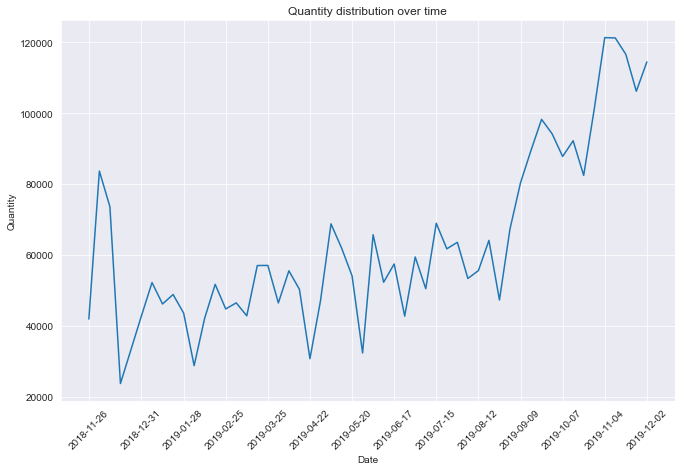

In [150]:
var_overtime('quantity')

The quantity over time (by week) graph starts with a sudden increase by the end of November and the beginning of December 2018, followed by an immediate drop until mid December, continues with a moderate fluctuating increase till mid August 2019, and finally steeply increases again to mid Novemver 2019.

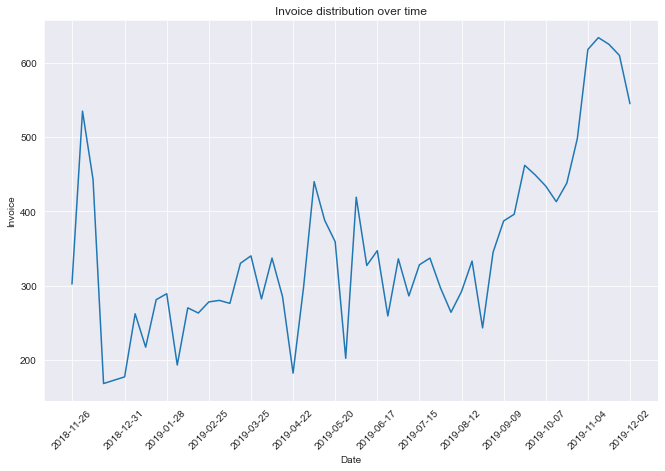

In [151]:
var_overtime('invoice')

As the invoice distribution over time graph shows, the number of orders by week is similar in shape to the qunatity graph, as it starts with a steep increase from the last days of Nobember to mis December 2018, and a sudden drop that stops and rises again after mid December. Then a long period of an overall gradual increase with many fluctuations, and finally a steep improvement from mid August 2018 till the end of the time period.

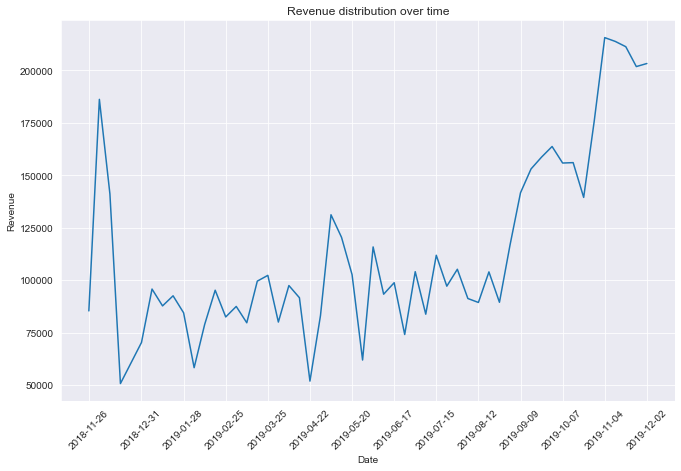

In [152]:
var_overtime('revenue')

The revenue over time looks very similar to the grpahs above, showing exactly the same pattern as described for the quantity and invoice.

## Product Range Analysis

**Product Score**<br>
The first step in the product range analysis part is building a product score by total revenue, total quantity and total orders (invoice). Then we'll categorize the products by score groups and study the leading groups.

For this purpose, we'll group the filtered data by product and build a function that calculates the product score:

In [153]:
products = new_df.groupby(['description'])[['revenue', 'quantity', 'customer_id', 'invoice']].agg({
    'revenue':'sum', 
    'quantity':'sum',
    'customer_id':'nunique',
    'invoice':'nunique'}).reset_index()
products.head()

,description,revenue,quantity,customer_id,invoice
0,4 PURPLE FLOCK DINNER CANDLES,285.70,142,31,38
1,50'S CHRISTMAS GIFT BAG LARGE,1927.63,1515,105,128
2,DOLLY GIRL BEAKER,1374.25,1051,99,169
3,I LOVE LONDON MINI BACKPACK,1083.02,248,56,83
4,I LOVE LONDON MINI RUCKSACK,4.15,1,1,1


The new table shows the total revenue, quantity and orders for each product, as well as the number of customers (unique) that bought it.<br>
Before adding the scores, we'll plot graphs for the top 10 products by revenue, quantity, and invoice for the whole period, using the next function:

In [154]:
def top_ten(column):
    top_products = products.sort_values(by=column, ascending=False).head(10)
    fig = px.bar(top_products, x='description', y=column, labels={
    'description' : 'Product',
    column : column.capitalize()
    })
    fig.update_layout(title_text='Top 10 products by ' + column, title_x=0.5)
    fig.show()

In [155]:
top_ten('revenue')

The top ten prodcuts in the graph above braught the highest revenues over the whole period.<br>
The 'Regecy Cakestand 3 Tier' takes the lead, bringing in more than 41K.

In [156]:
top_ten('quantity')

As the top 10 products by quantity graph shows, the products that bring in the highest revenues are not necessarily the ones that are sold in large quantities. <br>
For example, the 'REGENCY CAKESTAND 3 TIER' occupies the 1st place in total revenue plot, but is not among the top 10 products by quantity. <br>
These dramatic changes between the products in the two graphs is affected by the unit price, as the 'REGENCY CAKESTAND 3 TIER' unit costs 12.75, whereas the 'ASSORTED COLOUR BIRD ORNAMENT' that occupies the 1st place in qunatity costs only 1.69.

In [157]:
top_ten('invoice')

When it comes to the total number of orders for each product, we can notice of similarity in the leading products. It seems that products that were ordered frequently (appeared in many different orders) brought higher revenues comparing to products that were sold in large quantities.

**The most frequently refunded products**<br>
As refunded product are marked with negative quantity value, we'll retrieve only the negative quantity data and check whether some products are more likely to be refunded than others:

In [158]:
refunded = data[data['quantity'] < 0].groupby(['description'])[['quantity','invoice']].agg({
    'quantity':'sum',
    'invoice':'nunique'
}).reset_index()
refunded

,description,quantity,invoice
0,50'S CHRISTMAS GIFT BAG LARGE,-2,1
1,DOLLY GIRL BEAKER,-7,2
2,OVAL WALL MIRROR DIAMANTE,-5,3
3,SET 2 TEA TOWELS I LOVE LONDON,-8,3
4,SPACEBOY BABY GIFT SET,-6,3
...,...,...,...
2105,wrongly coded-23343,-800,1
2106,wrongly marked carton 22804,-256,1
2107,wrongly marked. 23343 in box,-3100,1
2108,wrongly sold as sets,-600,1


We can notice that products are all written in uppercase characters, while other items that account for negative quantity are lowercase.<br>
We'll filter the above table, retrieving only descriptions written in uppercase:

In [159]:
refunded = refunded[refunded['description'].str.isupper() == True]
refunded.sort_values(by='invoice', ascending=False).head(10)

,description,quantity,invoice
1437,REGENCY CAKESTAND 3 TIER,-855,180
1342,POSTAGE,-147,124
918,JAM MAKING SET WITH JARS,-247,87
1572,SET OF 3 CAKE TINS PANTRY DESIGN,-154,73
1495,ROSES REGENCY TEACUP AND SAUCER,-437,54
1747,STRAWBERRY CERAMIC TRINKET BOX,-362,52
1361,RECIPE BOX PANTRY YELLOW DESIGN,-151,47
1021,LUNCH BAG RED RETROSPOT,-574,43
939,JUMBO BAG RED RETROSPOT,-1115,43
1932,WHITE HANGING HEART T-LIGHT HOLDER,-2578,42


Dropping the POSTAGE and SAMPLES descriptions:

In [160]:
refunded = refunded[(refunded['description'] != 'POSTAGE') & (refunded['description'] != 'SAMPLES')]\
.sort_values(by='invoice', ascending=False).head(10)
refunded

,description,quantity,invoice
1437,REGENCY CAKESTAND 3 TIER,-855,180
918,JAM MAKING SET WITH JARS,-247,87
1572,SET OF 3 CAKE TINS PANTRY DESIGN,-154,73
1495,ROSES REGENCY TEACUP AND SAUCER,-437,54
1747,STRAWBERRY CERAMIC TRINKET BOX,-362,52
1361,RECIPE BOX PANTRY YELLOW DESIGN,-151,47
939,JUMBO BAG RED RETROSPOT,-1115,43
1021,LUNCH BAG RED RETROSPOT,-574,43
789,GREEN REGENCY TEACUP AND SAUCER,-143,42
1932,WHITE HANGING HEART T-LIGHT HOLDER,-2578,42


Now we would like to check the share of the refunded orders from all orders of each product. We'll match each product in the list with the corresponding number of orders in the filtered data, assuming that a refunded order was first counted as a purchase.

Merging the tables and dropping unnecesary columns:

In [161]:
refunded = pd.merge(refunded, products, on='description', how='left')
refunded = refunded[['description','invoice_x','invoice_y']]

Renaming columns, adding the relative share column:

In [162]:
refunded.columns=['description','refunded_orders','total_orders']
refunded['refunded_share(%)'] = refunded['refunded_orders'] / refunded['total_orders'] *100
refunded.sort_values(by='refunded_share(%)', ascending=False)

,description,refunded_orders,total_orders,refunded_share(%)
0,REGENCY CAKESTAND 3 TIER,180,1362,13.215859
1,JAM MAKING SET WITH JARS,87,1065,8.169014
4,STRAWBERRY CERAMIC TRINKET BOX,52,685,7.591241
2,SET OF 3 CAKE TINS PANTRY DESIGN,73,1323,5.517763
3,ROSES REGENCY TEACUP AND SAUCER,54,1028,5.252918
5,RECIPE BOX PANTRY YELLOW DESIGN,47,1077,4.363974
8,GREEN REGENCY TEACUP AND SAUCER,42,989,4.246714
7,LUNCH BAG RED RETROSPOT,43,1462,2.941176
6,JUMBO BAG RED RETROSPOT,43,1851,2.323069
9,WHITE HANGING HEART T-LIGHT HOLDER,42,1898,2.212856


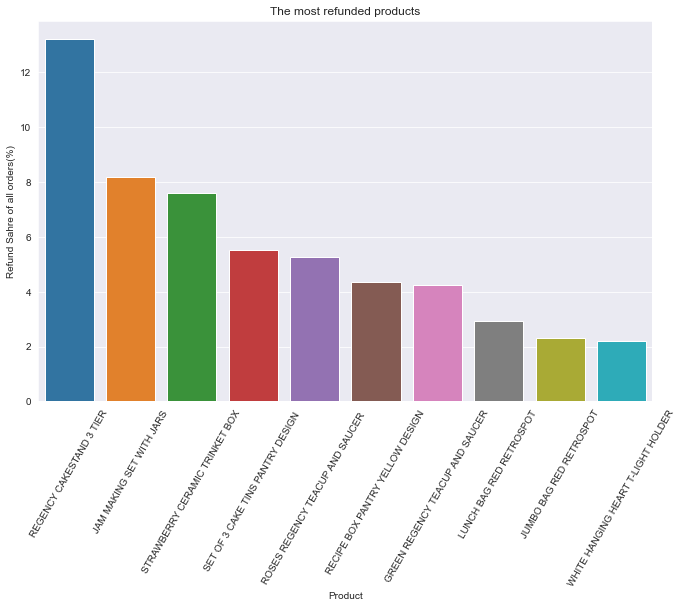

In [163]:
plt.figure(figsize=(11,7))
sns.barplot(data=refunded.sort_values(by='refunded_share(%)', ascending=False),
            x='description', y='refunded_share(%)')
plt.title ('The most refunded products')
plt.xticks(rotation=60)
plt.xlabel('Product')
plt.ylabel('Refund Sahre of all orders(%)')
plt.show()

The graph shows that the most refunded product is the 'Regency Cakestand 3 Tier', with more than 13% of the orders refunded. This product was presented earlier as the leading product in revenue, while not taking into account the latest findings. 

**Product Score**<br>
The first step in the product range analysis part is building a product score by total revenue, total quantity and total orders (invoice). Then we'll categorize the products by score groups and study the leading groups.<br>
For this purpose, we'll build a function that calculates the product score:

In [164]:
def product_score(row):
    x=row['revenue']
    y=row['quantity']
    z=row['invoice']
    
    rev_score = 0
    quant_score = 0
    order_score = 0
    
    if x <= np.quantile(products['revenue'], 0.5):
        rev_score = 1
    if np.quantile(products['revenue'], 0.75) > x > np.quantile(products['revenue'], 0.5):
        rev_score = 2
    if x > np.quantile(products['revenue'], 0.75):
        rev_score= 3
    
    if y <= np.quantile(products['quantity'], 0.5):
        quant_score = 1
    if np.quantile(products['quantity'], 0.75) > y > np.quantile(products['quantity'], 0.5):
        quant_score = 2
    if y > np.quantile(products['quantity'], 0.75):
        quant_score = 3 
        
    if z <= np.quantile(products['invoice'], 0.5):
        order_score = 1
    if np.quantile(products['invoice'], 0.75) > z > np.quantile(products['invoice'], 0.5):
        order_score = 2
    if z > np.quantile(products['invoice'], 0.75):
        order_score = 3 
    total_score = rev_score + quant_score + order_score
    return total_score

In [165]:
products['product_score'] = products.apply(product_score, axis=1)
products.head()

,description,revenue,quantity,customer_id,invoice,product_score
0,4 PURPLE FLOCK DINNER CANDLES,285.70,142,31,38,3
1,50'S CHRISTMAS GIFT BAG LARGE,1927.63,1515,105,128,8
2,DOLLY GIRL BEAKER,1374.25,1051,99,169,8
3,I LOVE LONDON MINI BACKPACK,1083.02,248,56,83,5
4,I LOVE LONDON MINI RUCKSACK,4.15,1,1,1,3


Checking the number of products in each score:

In [166]:
products['product_score'].value_counts().reset_index().rename(columns={
    'index':'score',
    'product_score':'number_of_products'
}).sort_values(by='score', ascending=False)

,score,number_of_products
1,9,635
3,8,336
6,7,287
2,6,446
5,5,300
4,4,313
0,3,1648


The above table shows that 634 products got the maximal score - 9, 336 products with score 8, and 284 products with score 7. <br>
The lowest score of 3 turned out to be the most frequent score (1650 products).

Presenting the distribution in plot:

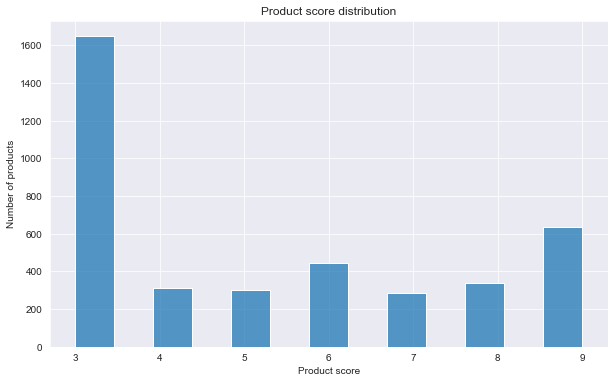

In [167]:
plt.figure(figsize=(10,6))
sns.histplot(products['product_score'])
sns.set_style('darkgrid')
plt.title('Product score distribution')
plt.xlabel('Product score')
plt.ylabel('Number of products')
plt.show()

We can assume at this point that the products with the low scores 3-5 are the first groups to be taken out of the product range, as they don't bring high revenues, are not being ordered often, and are sold in small quantity.

**Best score groups analysis**<br>
Back to the products score, we'll split the data by score groups, focusing on the 3 leading groups for further analysis:

In [168]:
top_scores = products.query('product_score == 7 or product_score == 8 or product_score == 9')
top_scores.head()

,description,revenue,quantity,customer_id,invoice,product_score
1,50'S CHRISTMAS GIFT BAG LARGE,1927.63,1515,105,128,8
2,DOLLY GIRL BEAKER,1374.25,1051,99,169,8
7,RED SPOT GIFT BAG LARGE,1673.92,1313,81,102,8
8,SET 2 TEA TOWELS I LOVE LONDON,3973.25,1231,125,258,9
13,10 COLOUR SPACEBOY PEN,4512.89,5148,175,308,9


To plot the core parameters - revenue, quantity, invoice - over time for each score groups, we need to create seperate dataset for the top_scores products. We'll take the data for the 3 groups from the raw data, thus keep the dates, and add the score label. Then group by weeks like we did earlier.

In [169]:
top_3_final = new_df[new_df['description'].isin(top_scores['description'])]
top_3_final = top_3_final.merge(top_scores[['description','product_score']], on='description', how='left')
top_3_final.sample(5)

,invoice,stock_code,description,quantity,invoice_date,unit_price,customer_id,revenue,date,product_score
148872,556080,21154,RED RETROSPOT OVEN GLOVE,15,2019-06-06 15:21:00,3.29,NaN,49.35,2019-06-06,9
300241,573245,22169,FAMILY ALBUM WHITE PICTURE FRAME,1,2019-10-26 12:08:00,8.50,17841.0,8.50,2019-10-26,8
165473,558199,22501,PICNIC BASKET WICKER LARGE,2,2019-06-25 12:58:00,9.95,17110.0,19.90,2019-06-25,8
334913,576644,21621,VINTAGE UNION JACK BUNTING,1,2019-11-14 10:01:00,12.46,NaN,12.46,2019-11-14,9
61593,544463,82494L,WOODEN FRAME ANTIQUE WHITE,6,2019-02-18 14:31:00,2.95,12988.0,17.70,2019-02-18,9


In [170]:
print('Number of products in the top 3 scores data:', top_3_final['description'].nunique())

Number of products in the top 3 scores data: 1258


In [171]:
top_3_final['date'].min(), top_3_final['date'].max()

(Timestamp('2018-11-29 00:00:00'), Timestamp('2019-12-07 00:00:00'))

The leading products maintain the complete time range.

**The best month / day of sales**<br>
Using the filtered data (top 3) we'll check for the month in the 12-month period that braught in the highest revenues, by extracting the month of date and add it in a new column, then group by months and sum the revenues.

In [172]:
top_3_final['month'] = top_3_final['date'].dt.to_period('M')
top_3_months = top_3_final.groupby(['month']).agg({
    'quantity':'sum',
    'invoice':'nunique',
    'revenue':'sum'}).sort_values(by='month').reset_index()
top_3_months['raletive_share(%)'] = top_3_months['revenue'] / top_3_months['revenue'].sum() * 100
top_3_months

,month,quantity,invoice,revenue,raletive_share(%)
0,2018-11,26105,237,49472.75,0.987159
1,2018-12,146952,1166,311932.71,6.224180
2,2019-01,162256,1107,298498.77,5.956125
3,2019-02,131016,976,250602.67,5.000425
4,2019-03,174857,1286,318402.59,6.353278
5,2019-04,151392,1076,268687.49,5.361283
6,2019-05,219174,1597,410248.44,8.185933
7,2019-06,189565,1367,333041.02,6.645367
8,2019-07,222688,1364,372894.18,7.440581
9,2019-08,221771,1288,378659.30,7.555616


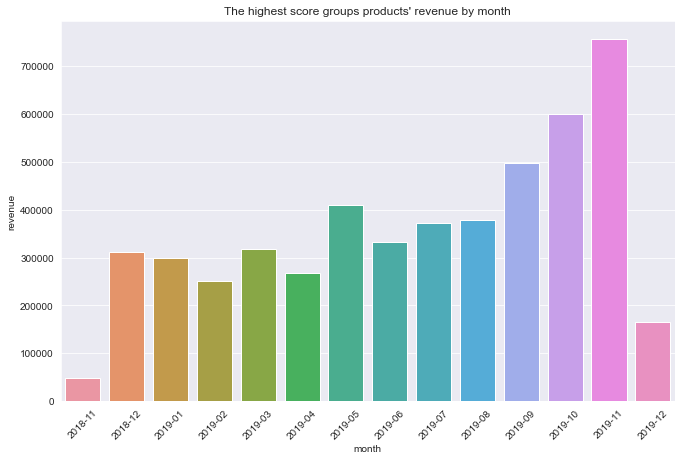

In [173]:
plt.figure(figsize=(11,7))
sns.barplot(data=top_3_months, x='month', y='revenue')
plt.title("The highest score groups products' revenue by month")
plt.xticks(rotation=45)
plt.show()

The sales of the top 3 score groups by month shows that November 2019 was the best sales month, taking the lead in all parameters, accounting for more than 15% of the overall sales of the period.<br>
One probable explanation is the 2019 black friday (2019-11-29) campaigns, events and discounts. At the bottom of the list are the two months that barely has records in the data - only 2 days for November 2018 and about a week for December 2019. <br>
Lets dig deeper and break the sales down by days:

In [174]:
top_3_final.groupby(['date']).agg({
    'quantity':'sum',
    'invoice':'nunique',
    'revenue':'sum'}).sort_values(by='revenue', ascending=False).head(10)

,quantity,invoice,revenue
date,,,
2019-12-03,23544,118,44797.82
2019-11-14,20992,117,38942.09
2019-12-06,18246,113,37155.70
2019-11-08,20726,119,36335.93
2019-11-06,18546,102,35765.67
2019-11-27,17118,122,35286.75
2019-11-15,20950,129,35115.88
2019-11-21,18604,118,34219.66
2019-11-20,19412,122,34119.04


It turns out that the best sales day was rather the 3rd of December 2019.<br>
However, 8 out of the 10 leading sales days were in November 2019 as expected.

**Chained products**<br>
By the structure of the data we can notice of the products that were purchased in one order. Those are listed in one after the other with the same invoice number, and the same timestamp. In order to get these sequences we'll group the raw data (so we will cover all the possible sequences) by invoice in a new table, and retrieve all the duplicated values in 'invoice' column:

In [175]:
chained_products = top_3_final[top_3_final['invoice'].duplicated(keep=False)]
chained_products

,invoice,stock_code,description,quantity,invoice_date,unit_price,customer_id,revenue,date,product_score,month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850.0,15.30,2018-11-29,9,2018-11
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850.0,20.34,2018-11-29,9,2018-11
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850.0,22.00,2018-11-29,9,2018-11
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850.0,20.34,2018-11-29,9,2018-11
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850.0,20.34,2018-11-29,9,2018-11
...,...,...,...,...,...,...,...,...,...,...,...
385543,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,2019-12-07 12:50:00,4.15,12680.0,16.60,2019-12-07,9,2019-12
385544,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2019-12-07 12:50:00,2.10,12680.0,12.60,2019-12-07,9,2019-12
385545,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2019-12-07 12:50:00,4.15,12680.0,16.60,2019-12-07,9,2019-12
385546,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2019-12-07 12:50:00,4.15,12680.0,16.60,2019-12-07,7,2019-12


To group all the products that are related to the same invoice, we'll join the relevant rows to one row using transform method, and store the products in the 'seqeunce' column:

In [176]:
chained_products['sequence'] = chained_products.groupby(['invoice'])['description'].\
transform(lambda x:','.join(x))
chained_products.head()

C:\Users\user\AppData\Local\Temp/ipykernel_10340/3731519720.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,invoice,stock_code,description,quantity,invoice_date,unit_price,customer_id,revenue,date,product_score,month,sequence
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850.0,15.30,2018-11-29,9,2018-11,"WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL..."
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850.0,20.34,2018-11-29,9,2018-11,"WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL..."
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850.0,22.00,2018-11-29,9,2018-11,"WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL..."
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850.0,20.34,2018-11-29,9,2018-11,"WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL..."
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850.0,20.34,2018-11-29,9,2018-11,"WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL..."


Keeping all the duplicates when creating the tables caused displaying the products sequence in each of the invoice rows, so now we'll drop the duplicates and display only the invoice and sequence: 

In [177]:
chained_products = chained_products[['invoice','sequence']].drop_duplicates()
chained_products.head()

,invoice,sequence
0,536365,"WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL..."
8,536367,"ASSORTED COLOUR BIRD ORNAMENT,POPPY'S PLAYHOUS..."
18,536368,"JAM MAKING SET WITH JARS,BLUE COAT RACK PARIS ..."
21,536370,"ALARM CLOCK BAKELIKE GREEN,STARS GIFT TAPE ,VI..."
36,536373,"WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL..."


The above table shows sequences that are too long for our task. <br>
We'll search the products sequences for pairs of products that were ordered together, and display the top 20 sequences:

In [178]:
count = Counter()
for row in chained_products['sequence']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list,2)))

count.most_common(10)

[(('KEY FOB ', 'KEY FOB '), 775),
 (('KEY FOB ', ' BACK DOOR '), 573),
 (('KEY FOB ', ' SHED'), 534),
 (('JUMBO BAG PINK POLKADOT', 'JUMBO BAG RED RETROSPOT'), 493),
 (('KEY FOB ', ' FRONT  DOOR '), 469),
 (('GREEN REGENCY TEACUP AND SAUCER', 'ROSES REGENCY TEACUP AND SAUCER '),
  468),
 (('JUMBO SHOPPER VINTAGE RED PAISLEY', 'JUMBO BAG RED RETROSPOT'), 434),
 (('JUMBO STORAGE BAG SUKI', 'JUMBO BAG RED RETROSPOT'), 410),
 (('SET 3 RETROSPOT TEA', 'COFFEE'), 405),
 (('SET 3 RETROSPOT TEA', 'SUGAR'), 405)]

The list above shows the most popular 2 products pairs that are orderes together.
'KEY FOB' and 'BACK DOOR' pair takes the lead. 'KEY FOB' appears in 4 out of the 5 first places of the table (including the first pair where it is duplicated for yet unknown reason.

**The high score products groups over time - total values**<br>
We'll plot graphs of total quantity, revenue and number of orders (invoice) over time for the leading product by score, using the a function that is based on the one we created earlier (with the reqiured adjustments). <br>
For this purpose, and for further analysis, we'll split the top scores table by score group: 

In [179]:
score_9 = top_3_final.query('product_score == 9')
score_8 = top_3_final.query('product_score == 8')
score_7 = top_3_final.query('product_score == 7')

In [180]:
print('Amount of products in each score group:\n'
      'score 9:', score_9['description'].nunique(),'\n'
      'score 8:', score_8['description'].nunique(),'\n'
      'score 7:', score_7['description'].nunique())

Amount of products in each score group:
score 9: 635 
score 8: 336 
score 7: 287


The number of products in score group 9 is more than the other two combined, thus we expect to see significant differences in the graphs that present the total values for each group.<br>
We'll take that into account and check also relative comparable parameters as the average order size.

Grouping the sales data by days and weeks in seperate tables:

In [181]:
score_9_days = score_9.groupby(['date']).agg({'quantity':'sum', 'invoice':'nunique', 'revenue':'sum'})\
.reset_index()
score_8_days = score_8.groupby(['date']).agg({'quantity':'sum', 'invoice':'nunique', 'revenue':'sum'})\
.reset_index()
score_7_days = score_7.groupby(['date']).agg({'quantity':'sum', 'invoice':'nunique', 'revenue':'sum'})\
.reset_index()

score_9_days['week'] = score_9_days['date'] - pd.to_timedelta(score_9_days['date'].dt.weekday, unit='D')
score_8_days['week'] = score_8_days['date'] - pd.to_timedelta(score_8_days['date'].dt.weekday, unit='D')
score_7_days['week'] = score_7_days['date'] - pd.to_timedelta(score_7_days['date'].dt.weekday, unit='D')

score_9_weeks = score_9_days.groupby(['week']).agg({
    'quantity':'sum', 'invoice':'sum', 'revenue':'sum'}).reset_index()
score_8_weeks = score_8_days.groupby(['week']).agg({
    'quantity':'sum', 'invoice':'sum', 'revenue':'sum'}).reset_index()
score_7_weeks = score_7_days.groupby(['week']).agg({
    'quantity':'sum', 'invoice':'sum', 'revenue':'sum'}).reset_index()

score_9_weeks.head()

,week,quantity,invoice,revenue
0,2018-11-26,24944,287,49520.38
1,2018-12-03,50834,505,109065.53
2,2018-12-10,39430,412,77975.77
3,2018-12-17,12368,144,27510.34
4,2018-12-31,20631,159,35914.81


Plotting the variables over time graphs:

In [182]:
def top_score_overtime(column):
    plt.figure(figsize=(11,7))
    plt.plot(score_9_weeks['week'], score_9_weeks[column], label='Score 9')
    plt.plot(score_8_weeks['week'], score_8_weeks[column], label='Score 8')
    plt.plot(score_7_weeks['week'], score_7_weeks[column], label='Score 7')
    plt.title('Total ' + column + ' over time - leading score groups')
    plt.grid(True, axis='x')
    plt.xticks(score_9_weeks['week'], rotation=45)
    plt.locator_params(axis='x', nbins=14)
    plt.xlabel('Date')
    plt.ylabel(column.capitalize())
    plt.legend()
    plt.show()

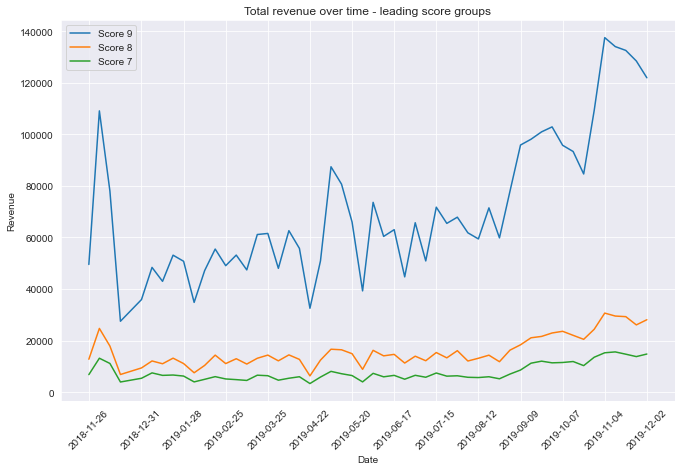

In [183]:
top_score_overtime('revenue')

The graph of total revenue over time shows that score group 9 products are sold over the period in the same pattern as the whole range of products, as we plotted previously. Starts with the peak of November 2018, followed by a rapid drop through December 2018, then moderately increases until September 2019 with many fluctuations, and finally a significant increase in October-November 2019.<br>
Through a careful observation we can see that score groups 7 and 8 have the same tendencies over the period, but in much lower values and narrow range. <br>
This finding might suggest that the revenues that come from the products of score group 9 have a crucial part in the overall revenues. <br> 

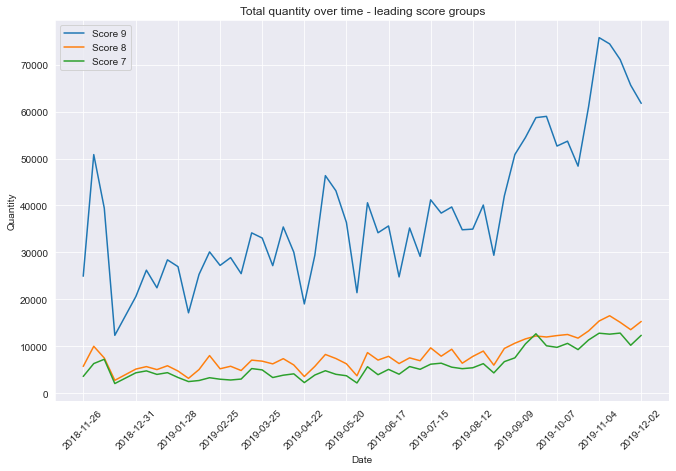

In [184]:
top_score_overtime('quantity')

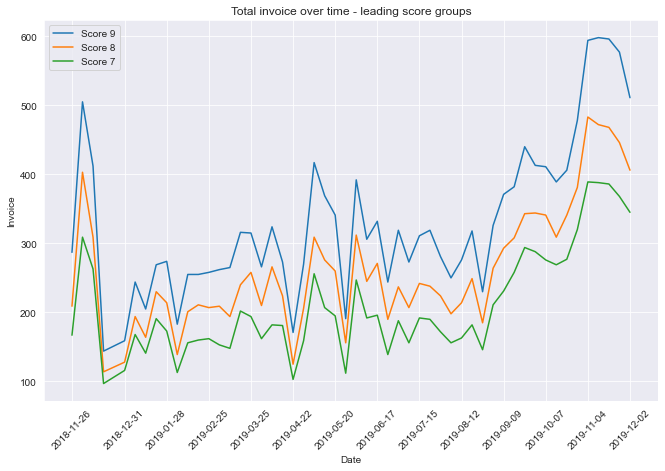

In [185]:
top_score_overtime('invoice')

The quantity and number of orders (invoice) graphs also indicate similarity between score group 9 and the original product range, whereas score groups 7 and 8 resemble in tendencies over the period but lag behind in total values. In the invoice graph we can notice of a greater similarity in the graph fluctuations between the group. As mentioned before, this result is affected by the groups size as well.<br>
We might assume at this point that many of the products that we would recommend to include in the final product range will come from score group 9, though a further investigation is needed.

**Average order size over time**<br>
To better compare the revenues between groups, we'll show the differences in averge order size between the 3 leading score groups over the period.<br>
We'll add a new column for the average order size to the tables of weekly sales that we alredy created. 

In [186]:
score_9_weeks['average_order_size'] = score_9_weeks['revenue'] / score_9_weeks['invoice']
score_8_weeks['average_order_size'] = score_8_weeks['revenue'] / score_8_weeks['invoice']
score_7_weeks['average_order_size'] = score_7_weeks['revenue'] / score_7_weeks['invoice']

In [187]:
score_9_weeks.head()

,week,quantity,invoice,revenue,average_order_size
0,2018-11-26,24944,287,49520.38,172.544878
1,2018-12-03,50834,505,109065.53,215.971347
2,2018-12-10,39430,412,77975.77,189.261578
3,2018-12-17,12368,144,27510.34,191.044028
4,2018-12-31,20631,159,35914.81,225.879308


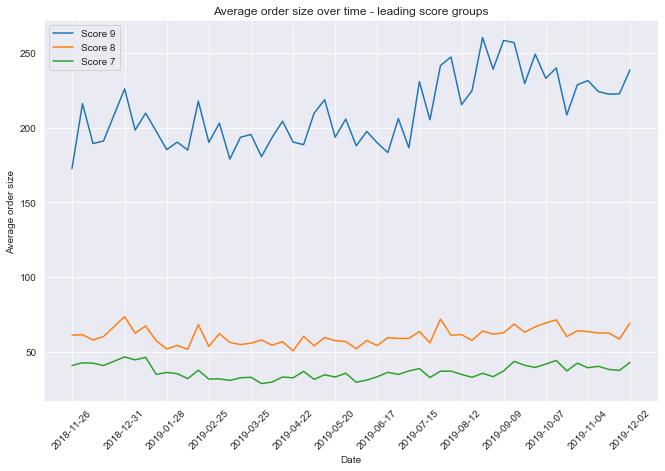

In [188]:
plt.figure(figsize=(11,7))
plt.plot(score_9_weeks['week'], score_9_weeks['average_order_size'], label='Score 9')
plt.plot(score_8_weeks['week'], score_8_weeks['average_order_size'], label='Score 8')
plt.plot(score_7_weeks['week'], score_7_weeks['average_order_size'], label='Score 7')
plt.title('Average order size over time - leading score groups')
plt.grid(True, axis='x')
plt.xticks(score_9_weeks['week'], rotation=45)
plt.locator_params(axis='x', nbins=14)
plt.xlabel('Date')
plt.ylabel('Average order size') 
plt.legend()
plt.show()

Here we can notice of a similar picture, as groups 7 and 8 show much lower values than group 9. The overall "behavior" of the groups' average order size over time is the same as seen in the previous graphs.
There are many fluctuantions through the period and one main rise around September 2019.  

**Score groups relative shares of all products**<br>
To find the share of each score group by revenues and number of products, we'll use the products table we created - data grouped by product - and plot a pie chart to present the findings:

In [189]:
products.head()

,description,revenue,quantity,customer_id,invoice,product_score
0,4 PURPLE FLOCK DINNER CANDLES,285.70,142,31,38,3
1,50'S CHRISTMAS GIFT BAG LARGE,1927.63,1515,105,128,8
2,DOLLY GIRL BEAKER,1374.25,1051,99,169,8
3,I LOVE LONDON MINI BACKPACK,1083.02,248,56,83,5
4,I LOVE LONDON MINI RUCKSACK,4.15,1,1,1,3


In [190]:
fig = px.pie(products, values='revenue', names='product_score', 
             title='Relative share of revenues by score group')
fig.update_layout(legend=dict(
    title="Score group:"
))
fig.show()

The pie cahrt clearly shows the dominance of score group 9 products, as they occupy 62% of the total revenue of the business over the data period.<br> Score group 8 follows with almost 14% of the total revenues. 

In [191]:
fig = px.pie(products, values='invoice', names='product_score', 
             title='Relative share of number of orders by score group')
fig.update_layout(legend=dict(
    title="Score group:"
))
fig.show()

Score group 9 takes more than 55% of the overall orders.

**Top 10 products by core parameters - score group 9**<br>
Previously we presented the top 10 products bu core parameter, based on the raw data.<br>
Given our last findings, we will plot these graphs only for the score group 9, adding the number of cusotmers that baught each product, and look for similarities.

In [192]:
top_products_score9 = score_9.groupby(['description'])[['revenue','quantity','invoice','customer_id']]\
.agg({
    'revenue':'sum', 
    'quantity':'sum',
    'invoice':'nunique',
    'customer_id':'nunique'}).reset_index()
top_products_score9.head()

,description,revenue,quantity,invoice,customer_id
0,SET 2 TEA TOWELS I LOVE LONDON,3973.25,1231,258,125
1,10 COLOUR SPACEBOY PEN,4512.89,5148,308,175
2,12 MESSAGE CARDS WITH ENVELOPES,2251.87,1253,243,145
3,12 PENCIL SMALL TUBE WOODLAND,2356.77,3360,350,189
4,12 PENCILS SMALL TUBE RED RETROSPOT,3219.27,4761,356,228


Plotting the bar graphs using the function:

In [193]:
for column in top_products_score9[['revenue','quantity','invoice']]:
    top_10 = top_products_score9.sort_values(by=column, ascending=False).head(10)
    fig = px.bar(top_10, x='description', y=column, labels={
    'description' : 'Product',
    column : column.capitalize()
    })
    fig.update_layout(title_text='Top 10 products by ' + column +' - score group 9', title_x=0.5)
    fig.show()

The leading score group's top 10 products by revenue, quantity and number of orders graphs are identical to the correspoding graphs of the original product range. That is, all the top leading products by core parameters total values come from score group 9.  

**Sales seasonality**<br>
The various graphs that show the sales parameters over the period clearly indicate a seasonality - increse in sales through the latter months of the year.<br>
To further investigate this idea in terms of quarters of year, we'll calculate total revenue for each quarter of the year in each score group, presenting the percentage change.

In [194]:
for group in [score_9, score_8, score_7]:
    quarters = group.groupby(group['date'].dt.to_period('Q'))['revenue'].sum().reset_index()
    quarters['change(%)'] = quarters['revenue'].pct_change()
    display(quarters)

,date,revenue,change(%)
0,2018Q4,264072.02,NaN
1,2019Q1,640926.94,1.427091
2,2019Q2,764862.10,0.193369
3,2019Q3,952812.02,0.245730
4,2019Q4,1134116.33,0.190283


,date,revenue,change(%)
0,2018Q4,62244.73,NaN
1,2019Q1,151671.01,1.436688
2,2019Q2,171297.28,0.129400
3,2019Q3,201523.72,0.176456
4,2019Q4,255451.10,0.267598


,date,revenue,change(%)
0,2018Q4,35088.71,NaN
1,2019Q1,74906.08,1.134763
2,2019Q2,75817.57,0.012168
3,2019Q3,94513.32,0.246589
4,2019Q4,132324.18,0.400059


The revenue by quarter tables show that the the revenues have constantly increased over the year, as the 4th quarter braught the highest revenues for all the 3 groups. <br>
Leave aside the 4th quarter of 2018 that is based on about a month of sales in our data, the steady increase in sales could have reached even higher revenues in the Q4 of 2019, given the fact that the last date recorded is 2019-12-07.<br>
Although gaining the lowest total revenue values, score group 7 had the greatest change in revenue between 3rd and 4th quarters of 2019.

## Hypotheses Testing

The former stages of analysis have led us to assume that score group 9 differs from groups 7 and 8 in revenues, quantities and number of orders. <br>
In this part we'll test the hypothesis that score group 9 is significantly better than the others in the average order size, which is metric that was chosen to represent the group's products worthwhileness.<br>
We'll use the daily sales datasets - one for each of the leading score groups - add the daily average order size, check normality of distrubtions using Shapiro-Wilk test, thus decide which test to use (T-test or Mann Whitnet U) and pass it our samples of average order size. 

Preparing the datasets for samples:

In [195]:
score_9_days.head()

,date,quantity,invoice,revenue,week
0,2018-11-29,9248,104,18748.84,2018-11-26
1,2018-11-30,9668,126,16770.96,2018-11-26
2,2018-12-01,6028,57,14000.58,2018-11-26
3,2018-12-03,7367,79,13924.48,2018-12-03
4,2018-12-04,9882,94,21910.74,2018-12-03


In [196]:
score_9_days['average_order_size'] = score_9_days['revenue'] / score_9_days['invoice']
score_8_days['average_order_size'] = score_8_days['revenue'] / score_8_days['invoice']
score_7_days['average_order_size'] = score_7_days['revenue'] / score_7_days['invoice']
score_9_days.head()

,date,quantity,invoice,revenue,week,average_order_size
0,2018-11-29,9248,104,18748.84,2018-11-26,180.277308
1,2018-11-30,9668,126,16770.96,2018-11-26,133.102857
2,2018-12-01,6028,57,14000.58,2018-11-26,245.624211
3,2018-12-03,7367,79,13924.48,2018-12-03,176.259241
4,2018-12-04,9882,94,21910.74,2018-12-03,233.092979


In [197]:
score_8_days.head()

,date,quantity,invoice,revenue,week,average_order_size
0,2018-11-29,2366,75,4656.60,2018-11-26,62.088000
1,2018-11-30,2139,85,4215.85,2018-11-26,49.598235
2,2018-12-01,1245,49,3901.21,2018-11-26,79.616531
3,2018-12-03,1849,67,3501.31,2018-12-03,52.258358
4,2018-12-04,2205,75,5064.23,2018-12-03,67.523067


In [198]:
score_7_days.head()

,date,quantity,invoice,revenue,week,average_order_size
0,2018-11-29,1205,58,2801.11,2018-11-26,48.295000
1,2018-11-30,1479,69,2279.39,2018-11-26,33.034638
2,2018-12-01,937,40,1734.46,2018-11-26,43.361500
3,2018-12-03,950,56,1562.98,2018-12-03,27.910357
4,2018-12-04,1290,58,2490.39,2018-12-03,42.937759


In [199]:
print('Score group 9 average oder size:', score_9_days['average_order_size'].mean())
print('Score group 8 average oder size:', score_8_days['average_order_size'].mean())
print('Score group 7 average oder size:', score_7_days['average_order_size'].mean())

Score group 9 average oder size: 210.2112103063182
Score group 8 average oder size: 60.31933753710554
Score group 7 average oder size: 36.32094361897506


Conducting the Shapiro-Wilk test, testing the following hypotheses for each score group:
- H0: The distribution of the daily average order size is normal for the score group sample
- H1: The daily avergae order size in not normally distributed for the score group sample 

In [200]:
def shapiro_results(sample):
    alpha=0.05
    stat, pvalue = st.shapiro(sample)
    print ('p-value:', pvalue)
    if pvalue > alpha:
        print("We can't reject the null hypothesis")
    else:
        print('We reject the null hypothesis')

In [201]:
shapiro_results(score_9_days['average_order_size'])

p-value: 2.8381947458910872e-08
We reject the null hypothesis


The p-value from the the Shapiro-Wilk test for score group 9 is below the defined statistical significance threshold of 0.05, thus we reject the null hypothesis and consider the daily average order size in this group as not normally distributed.

In [202]:
shapiro_results(score_8_days['average_order_size'])

p-value: 0.00011411308514652774
We reject the null hypothesis


In [203]:
shapiro_results(score_7_days['average_order_size'])

p-value: 0.0003908524813596159
We reject the null hypothesis


As for scroe groups 8 and 7, we reject the null hypothesis based on the p-values, means that the average order size distributions of these groups is not considered normal.<br>

The next step is comparing the average order size between the score groups. Since the samples are not normally distributed we'll use Mann-Whitney U test for statistically significant difference between groups, testing the following hypotheses:
- H0: There is no significant difference in daily average order size between the score groups.
- H1: The daily average order size of score group 9 differs from the daily average order size of groups 8 and 7.

Building the function for cunducting the Mann-Whitney U test and print the the p-value:

In [204]:
def mann_whitney_results(sample1, sample2):
    alpha=0.05
    stats, p_value = st.mannwhitneyu(sample1, sample2)
    print('P-value:', p_value)
    if p_value > alpha:
        print("We can't reject the null hypothesis")
    else:
        print('We reject the null hypothesis')

In [205]:
mann_whitney_results(score_9_days['average_order_size'],score_8_days['average_order_size'])

P-value: 2.4604960878290785e-101
We reject the null hypothesis


In [206]:
mann_whitney_results(score_9_days['average_order_size'],score_7_days['average_order_size'])

P-value: 2.4604960878290785e-101
We reject the null hypothesis


In [207]:
mann_whitney_results(score_8_days['average_order_size'],score_7_days['average_order_size'])

P-value: 5.354690025321966e-83
We reject the null hypothesis


The P-values from the above Mann-Whitney U test indicate that the comparison between groups 9 and 8 / 7 reject the null hypothesis, means the difference in average order size is statistically significant. In other words, score group 9 average order size is significantly different from (better than) score group 8 or 7.<br>
We got a similar result in the comparison between groups 8 and 7 - a statistically significant difference in average order size.

While summarizing the tests results we should comment that in the above hypotheses testing we set the statistical significnace threshold (alpha) to the common value of 0.05. However, testing the same samples multiple times (in our testing - twice for each group) increase the probability of error as the FWER (Family-wise error rate) describes.<br>
To prevent the increase of the probability of error we should use multiple comparison correction such as the Bonferroni correction. According to the Bonferroni correction, the alpha value for the set of tests should be the alpha of a single test devided by the number of tests performed. In our case - alpha = 0.05 / 2 = 0.025 (2.5%).<br>
Back to our hypotheses testing results, adjusting the significance level is meaningless since the Mann-Whitney U tests we conducted resulted in p-values that are much lower than 0.025. Hence, even if we took into account the Bonferonni correction and set the threshold to 0.025, the results and conclusions from our tests would have remained the same.

## Conclusions and Recommendations

### Main results of the study
**EDA and raw product range analysis**<br>
- Most of the orders are of 1-2 pieces/items per orers, and the vast majority of values are concentrated up to 12 per order.
- most of the products are priced 5 or less, with the highest frequency between 1-2.
- The revenue from orders, which is the product of qunatity and unit price of each order, shows a noticable amount of orders between 4-8, as most of the overall orders revenue is less than 20.
- The correlation matrix indicates a strong positive correlation for quantity-revenue (r=0.72) and unit price-revenue (r=0.87) pairs, while quantity-unit price vaiables are weakly correlated (r=0.39).
- Sales distribution over time has increased dramatically through the last 3 months of the period (September 2019 – December 2019) in all the core parameters (quantity, orders, revenue).
- The leading products by revenue are ‘Regency Cakestand 3 Tier’, ‘Whtie Hanging Heart T-Light Holder’ and ‘Jumbo Bag Red Rertospot’. 
- The most sold products are ‘Whtie Hanging Heart T-Light Holder’, ‘Jumbo Bag Red Rertospot’, ‘Lunch Bag Red Rertospot’.
- The most refunded product is the 'Regency Cakestand 3 Tier', with more than 13% of the orders refunded.

**Filtered product range by score groups analysis**<br>
- The number of products in the leading 3 groups by the scoring system was 1254, among which 654 were sored 9 (the highest score). The following results are relevant for the 3 highest score groups.
- The highest revenues month was November 2019, account for more than 15% of the 3 groups overall sales.
- The most commonly paired product is ‘Key Fob’ – appeared in four different combinations among the leading five pairs of products.
- Sales over time was found similar (in graph shape and tendency) between the leading groups and the whole range, and within the leading groups as well – a moderate increase throughout the first 3 quarters of the year, followed by a significant increase in the last quarter.
- Score group 9 gained the highest revenues and number of orders among all groups (shares of 62% and 55% respectively).
- In the relative metric – average order size – score group 9 took the lead once again. <br>
The hypotheses testing resulted in significant difference in average order size between score group 9 and 8, 9 and 7, and between score groups 8 and 7.

As an overall recommendation we would suggest to put the main focus on the score group 9's products. This group includes 654 producs, out of about 4000 in the raw range. <br>
These products have surpassed the other groups' products in every aspect of our analysis, thus seem to be high profit products of great importance to the online store's sales.<br>
Taking into acoount the seasonal pattern of the products sales, we would recommend to concentrate the marketing efforts in the 4th quarter of the year, especially around November.<br>

Further investigation is needed in order to zoom in on specific products in the leading group (beyond the narrow, observable top products range of the group), and determine which are more important and which are not, either through applying score categorization within the group or by other categorization method.<br>
However, The dataset has not contained information on how much products cost the store, or elaborate marketing  expenses (more detailed than ‘AMAZON FEE’ and ‘POSTAGE), thus leave influential factors of profitability out of our analysis. Such additional information might have changed our results which are currently based on transactions.